# Avaliação de estratégias para melhora de classificação com word embeddings estáticos.

Neste notebook apresenta-se a avaliação de diferentes estratégias de enriquecimento de embeddings estáticos para melhorar o desempenho de modelos na classificação de documentos. Neste notebook utilizaremos de recursos comumente utilizados em arquiteturas transformers, mais especificamente Positional Encoding e Self-Attention aplicados em menor escala para verificar o impacto destas estratégias na classificação de documentos. Para tal análise, utilizaremos a base de dados do jornal Folha de São Paulo disponível no link https://www.kaggle.com/marlesson/news-of-the-site-folhauol. Esta base conta com mais de 167 mil documentos e os atributos texto (conteúdo das notícias), title (título da notícia), category (e.g., esporte, colunas, mercado,...), subcategory (e.g., futebol), date (data de publicação) e link para notícia. Destes atributos utilizaremos o conteúdo de texto para produção de vetores densos o atributo category como rótulo para tarefa de classificação. Para construção de vetores densos estáticos utilizaremos o modelo Fasttext.

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import cld3
import nltk
from nltk.corpus import stopwords
from gensim.models import FastText
from scipy.special import softmax
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

# Parâmetros

* Para pré processar novamente o texto basta alterar a variável PREPROCESS para True.
* Para treinar novamente os modelos cbow e skip-gram basta alterar a variável TRAIN_EMBEDDINGS para True.
* Para produzir novas representações vetoriais dos documentos basta alterar a variável MAKE_EMBEDDINGS para True.

In [10]:
PREPROCESS = False
TRAIN_EMBEDDINGS = False
MAKE_EMBEDDINGS = True
BASE_COLS = ["colunas", "cotidiano", "esporte", "ilustrada", "mercado", "mundo", "poder"]

# Pré-Processando texto

Antes de produzir os vetores densos, aplicamos uma etapa de pré-processamento dos dados, constituída das seguintes sub-etapas: remoção de notícias em lingua não portuguesa, remoção de documentos com menos de 15 palavras, conversão de texto para lowercase, remoção de stop_words e pontuação e tokenização.

In [11]:
def get_language(text):

  return cld3.get_language(text)

def get_stop_words():
  nltk.download('stopwords')
  stop_words = { w:True for w in stopwords.words('portuguese') }
  return stop_words

def get_tokenizer():
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  return tokenizer

def clean_text(text, tokenizer, stop_words):
    tokens = [ word for word in tokenizer.tokenize(text.lower()) if word not in stop_words ]
    return " ".join(tokens)

In [55]:
if PREPROCESS:
  
  data_path = f"data/articles.csv"
  
  # Filtrando colunas do dataset.
  df = pd.read_csv(data_path).query(f"category in {BASE_COLS}")
  df = df[df.text.notna()]
  
  # Filtrando mensagens que não estão em portugues.
  lang_info = df.text.apply(lambda text: get_language(text))
  lang = [ d[0] for d in lang_info ]
  probs = [ d[1] for d in lang_info ]
  df["lang"] = lang
  df["probs"] = probs
  df = df[df.lang == 'pt']
  
  # Filtrando stopwords.
  tokenizer = get_tokenizer()
  stop_words = get_stop_words()
  df["text_clean"] = df.text.apply(lambda text: clean_text(text, tokenizer, stop_words))
  df.to_csv(f"data/pt_clean_text.csv", index=False)

  sample = df.sample(frac=0.18, random_state=42)
  sample.to_csv(f"data/pt_sample.csv", index=False)

else:
  df = pd.read_csv(f"data/pt_clean_text.csv")
  sample = pd.read_csv(f"data/pt_sample.csv")
  sample["sent_tokens"] = sample.text_clean.apply(lambda text: text.split(' '))
  sample["sent_len"] = sample.sent_tokens.apply(lambda tokens: len(tokens))

# Treinando/Carregando os modelos de word-embeddings.

Para produzir os vetores densos representantes do vocabulário, utilizamos o modelo Fasttext com os parâmetros: dimensão dos vetores (vector_size) 100, tamanho da janela (window) 10, frequência mínima de aparições para palavras (min_count) 3, alpha 0.025 e número de épocas 10. Treinamos dois modelos, um com cbow e outro com skip-gram.

In [13]:
def train_model(texts, sg=1):

  model = FastText(vector_size=100, window=10, min_count=3, alpha=0.025, min_alpha=0.025, workers=15, sg=sg)
  model.build_vocab(texts)
  for epoch in tqdm(range(10)):
    model.train(texts, total_examples=model.corpus_count, epochs=1)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
  return model

In [14]:
if TRAIN_EMBEDDINGS:
  df = pd.read_csv(f"data/pt_clean_text.csv")
  cbow_model = train_model(df.sent_tokens.values, sg=0)
  skip_model = train_model(df.sent_tokens.values, sg=1)
  cbow_model.save(f"models/fasttext_cbow")
  skip_model.save(f"models/fasttext_sg")
else:
  cbow_model = FastText.load("models/fasttext_cbow")
  skip_model = FastText.load("models/fasttext_sg")

### Estatísticas dos documentos. Tamanho máximo, mínimo, médio e desvio padrão do tamanho dos documentos.

In [15]:
sample.groupby("category").agg({"sent_len": ["max", "min", "mean", "std"]})

sent_len                            
               max min        mean         std
category                                      
colunas       1567   2  275.517763  133.992314
cotidiano     1237  16  256.950916  159.574418
esporte       1665  22  216.727247  143.771406
ilustrada     3886  16  249.976336  185.272439
mercado       6467   8  276.115907  204.021483
mundo         2249  25  281.860541  181.532158
poder         2905  14  280.942387  178.767552

Os documentos não possuem padrão bem definido em relação a quantidade de tokens para qualquer uma das categorias, como podemos ver, para todas as categorias temos um elevado desvio (acima de 140 para todas as categorias) padrão na quantidade de tokens médio dos documentos.

### Removendo documentos com menos de 15 palavras.

In [16]:
sample = sample[sample.sent_len > 15]

### Distribuição de documentos pelas classes.

Como mostrado no gráfico abaixo, as classes estão bem balanceadas, nenuma das classes possui o dobro dos documentos a outra.

<AxesSubplot:>

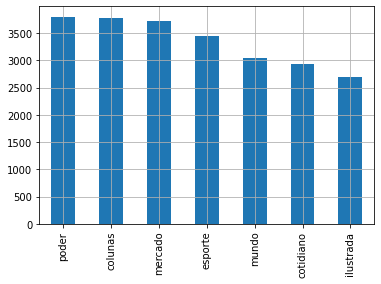

In [17]:
sample.category.value_counts().plot(kind='bar', grid=True)

### Obtendo TF-IDF das palavras.

In [56]:
tf = TfidfVectorizer(min_df=3)
_ = tf.fit_transform(df.text_clean)

In [60]:
def get_tfidf_norm(sent, cbow_model, tfidf):
    x = np.array([ tfidf.idf_[tfidf.vocabulary_[token]] for token in sent if token in tfidf.vocabulary_ and token in cbow_model.wv ])
    #x = x / np.max(x)
    return x
if MAKE_EMBEDDINGS:
    tfidf_matrix = np.array([ get_tfidf_norm(sent, cbow_model, tf) for sent in tqdm(sample.sent_tokens.values) ])
    np.save("embeddings/tfidf_scores.npy", tfidf_matrix, allow_pickle=True)
else:
    tfidf_matrix = np.load("embeddings/tfidf_scores.npy", allow_pickle=True)

100%|██████████| 10/10 [00:02<00:00,  3.88it/s]
/tmp/ipykernel_909794/3983148088.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tfidf_matrix = np.array([ get_tfidf_norm(sent, cbow_model, tf) for sent in tqdm(sample.sent_tokens.values[:10]) ])


### Funções para gerar as representações vetoriais.

In [20]:
def get_positional_embs(n_words=5559, dim=200):

    return np.vstack([positional_vector(i, dim=dim) for i in range(n_words)])


def positional_vector(pos, dim=100, denom=10000):

    pos_values = []
    for i in range(dim):
        pw = 2 * i
        if i % 2 == 0:
            res = np.sin(pos / np.power(denom, pw/dim))
        else:
            res = np.cos(pos / np.power(denom, pw/dim))
        pos_values.append(res)
    return np.array(pos_values)


def check_word(word, cbow_model, skip_model, tf=None):

    # Se a palavra estiver no cbow e no skipgram.
    if word in cbow_model.wv and word in skip_model.wv:
        # Se não estiver usando IDF.
        if tf is None:
            return True
        else:
            # Se a palavra estiver no vocabulário IDF.
            if word in tf.vocabulary_:
                return True
    return False


def tokens_to_embs(sent_tokens, cbow, skip, option=1, pos_embs=None, idf=None, tf=None):

    if option not in [1, 2, 3]:
        option = 2

    # Cbow somente
    if option == 1:
        words_vec = np.vstack([cbow.wv[token] for token in sent_tokens if check_word(
            token, cbow_model, skip_model, tf)])
    # Skip Gram
    elif option == 2:
        words_vec = np.vstack([cbow.wv[token] for token in sent_tokens if check_word(
            token, cbow_model, skip_model, tf)])
    # Skip e Cbow Combinados.
    elif option == 3:
        words_vec = np.vstack([np.hstack([cbow.wv[token], skip.wv[token]])
                              for token in sent_tokens if check_word(token, cbow_model, skip_model, tf)])

    if pos_embs is not None:
        words_vec += pos_embs[:words_vec.shape[0], :words_vec.shape[1]]
        return words_vec
    if idf is not None:
        return (words_vec.T * idf).T
    return words_vec


def get_raw_embs(sentences_tokes, cbow, skip, option=1, pos_embs=None, tfidf_matrix=None, tf=None):

    if tfidf_matrix is None:
        return np.vstack([np.mean(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, tf=tf), axis=0) for sent_tokens in sentences_tokes])
    else:
        return np.vstack([np.mean(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, idf=widf, tf=tf), axis=0) for sent_tokens, widf in zip(sentences_tokes, tfidf_matrix)])


def attention_eval(embs, norm="softmax", att_type="product"):

    if att_type == "product":
        w = softmax(np.inner(embs, embs), axis=1)
    else:
        w = cosine_similarity(embs, embs)

    context_words = np.dot(w, embs)

    if norm == "mean":
        return np.mean(context_words, axis=0)
    else:
        return softmax(np.sum(context_words, axis=0), axis=0)


def attention(sentences_tokes, cbow, skip, option=1, norm="mean", pos_embs=None, tfidf_matrix=None, tf=None, att_type="product"):

    if tfidf_matrix is None:
        return np.array([attention_eval(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, tf=tf), att_type=att_type) for sent_tokens in sentences_tokes])
    else:
        return np.array([attention_eval(tokens_to_embs(sent_tokens, cbow, skip, option=option, pos_embs=pos_embs, idf=widf, tf=tf), att_type=att_type) for sent_tokens, widf in zip(sentences_tokes, tfidf_matrix)])


def save_embs(dict_embs, embs_dir):

    for emb in dict_embs:
        np.save(f"{embs_dir}/{emb}.npy", dict_embs[emb], allow_pickle=True)


### Cross-Validation pipeline.

In [ ]:
def evaluate(dict_embs, y_true, dict_scores, kf):

    for key_emb in dict_embs:
        print(f"Embedding: {key_emb}")
        dict_scores[key_emb] = {}
        fold = 0
        # Para cada fold.
        for train_idx, test_idx in tqdm(kf.split(dict_embs[key_emb], y_true)):
            print(f"\tFold: {fold}")
            # Para cada classificador.
            for key_clf in dict_clfs:
                #print(f"\t\tClassifier: {key_clf}")
                dict_clfs[key_clf].fit(dict_embs[key_emb][train_idx], y_true[train_idx])
                y_pred = dict_clfs[key_clf].predict(dict_embs[key_emb][test_idx])
                if key_clf not in dict_scores[key_emb]:
                    dict_scores[key_emb][key_clf] = {}
                # Calculando métricas.
                if "micro" not in dict_scores[key_emb][key_clf]:
                    dict_scores[key_emb][key_clf]["micro"] = []
                dict_scores[key_emb][key_clf]["micro"].append(f1_score(y_true[test_idx], y_pred, average="micro"))
                if "macro" not in dict_scores[key_emb][key_clf]:
                    dict_scores[key_emb][key_clf]["macro"] = []
                dict_scores[key_emb][key_clf]["macro"].append(f1_score(y_true[test_idx], y_pred, average="macro"))
                if "precision" not in dict_scores[key_emb][key_clf]:
                    dict_scores[key_emb][key_clf]["precision"] = []
                dict_scores[key_emb][key_clf]["precision"].append(precision_score(y_true[test_idx], y_pred, average="macro"))
                if "recall" not in dict_scores[key_emb][key_clf]:
                    dict_scores[key_emb][key_clf]["recall"] = []
                dict_scores[key_emb][key_clf]["recall"].append(recall_score(y_true[test_idx], y_pred, average="macro"))
            fold += 1

# Generating Baseline Embeddings

In [ ]:
dict_embs = {}
if MAKE_EMBEDDINGS:
    dict_embs["cbow"] = get_raw_embs(sample.sent_tokens.values, cbow_model, skip_model, option=1)
    dict_embs["skip"] = get_raw_embs(sample.sent_tokens.values, cbow_model, skip_model, option=2)
    dict_embs["cbow_skip"] = get_raw_embs(sample.sent_tokens.values, cbow_model, skip_model, option=3)
    dict_embs["cbow-tf-idf"] = get_raw_embs(sample.sent_tokens.values, cbow_model, skip_model, option=1, tfidf_matrix=tfidf_matrix, tf=tf)
    dict_embs["skip-tf-idf"] = get_raw_embs(sample.sent_tokens.values, cbow_model, skip_model, option=2, tfidf_matrix=tfidf_matrix, tf=tf)
    dict_embs["cbow_skip-tf-idf"] = get_raw_embs(sample.sent_tokens.values, cbow_model, skip_model, option=3, tfidf_matrix=tfidf_matrix, tf=tf)
    save_embs(dict_embs, "embeddings")
else:
    dict_embs["cbow"] = np.load("embeddings/cbow.npy")
    dict_embs["skip"] = np.load("embeddings/skip.npy")
    dict_embs["cbow_skip"] = np.load("embeddings/cbow_skip.npy")
    dict_embs["cbow-tf-idf"] = np.load("embeddings/cbow-tf-idf.npy")
    dict_embs["skip-tf-idf"] = np.load("embeddings/skip-tf-idf.npy")
    dict_embs["cbow_skip-tf-idf"] = np.load("embeddings/cbow_skip-tf-idf.npy")

# Avaliação da baseline

Neste trabalho utilizaremos como baseline para as avaliações aqui feitas as seguintes representações: Fasttext-Cbow, Fasttext-Skip-Gram e Cbow-Skip-Gram (concatenação dos vetores duas estratégias).

In [ ]:
dict_clfs = {}
dict_clfs["LogisticRegression"] = LogisticRegression(max_iter=5000, n_jobs=10)

In [ ]:
dict_scores = {}
le = preprocessing.LabelEncoder()
le.fit(sample.category.values)
y_true = le.transform(sample.category.values)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
evaluate(dict_embs, y_true, dict_scores, kf)

In [ ]:
table = []
for emb in dict_scores:
    for clf in dict_scores[emb]:
        table.append([emb, np.mean(dict_scores[emb][clf]["macro"]), np.std(dict_scores[emb][clf]["macro"])])
pd.DataFrame(table, columns=["Embedding", "F1-Macro (Mean)", "Std"])

# Modelos propostos

In [ ]:
pos_embs = get_positional_embs()

In [47]:
dict_embs = {}
if MAKE_EMBEDDINGS:
    # Product Attention.
    dict_embs["cbow_skip-product"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3)
    dict_embs["cbow_skip-product-positional"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3)
    dict_embs["cbow_skip-tf-idf-product"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3, tfidf_matrix=tfidf_matrix)
    dict_embs["cbow_skip-tf-idf-product-positional"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    
    # Consine Attention
    dict_embs["cbow_skip-consise"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3, att_type="cosine")
    dict_embs["cbow_skip-consise-positional"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3, att_type="cosine")
    dict_embs["cbow_skip-tf-idf-consise"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3, tfidf_matrix=tfidf_matrix, att_type="cosine")
    dict_embs["cbow_skip-tf-idf-consise-positional"] = attention(sample.sent_tokens.values, cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix, att_type="cosine")

    save_embs(dict_embs, "embeddings")
else:
    dict_embs["cbow_skip-product"] = np.load("embeddings/cbow_skip-product.npy")
    dict_embs["cbow_skip-product-positional"] = np.load("embeddings/cbow_skip-product-positional.npy")
    dict_embs["cbow_skip-tf-idf-product"] = np.load("embeddings/cbow_skip-tf-idf-product.npy")
    dict_embs["cbow_skip-tf-idf-product-positional"] = np.load("embeddings/cbow_skip-tf-idf-product-positional.npy")

    dict_embs["cbow_skip-consise"] = np.load("embeddings/cbow_skip-consise.npy")
    dict_embs["cbow_skip-consise-positional"] = np.load("embeddings/cbow_skip-consise-positional.npy")
    dict_embs["cbow_skip-tf-idf-consise"] = np.load("embeddings/cbow_skip-tf-idf-consise.npy")
    dict_embs["cbow_skip-tf-idf-consise-positional"] = np.load("embeddings/cbow_skip-tf-idf-consise-positional.npy")

KeyboardInterrupt: 

### Cross-Validation

In [ ]:
evaluate(dict_embs, y_true, dict_scores, kf)

In [ ]:
with open("outputs/scores_idf.json","w") as fd:
    json.dump(dict_scores, fd)

### Positional Encoding

In [ ]:
if MAKE_EMBEDDINGS:
    dict_embs["cbow_postitional"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=1, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    dict_embs["skip_postitional"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=2, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    dict_embs["cbow_skip_postitional"] = get_raw_embs(sample.sentence_tokens.values, cbow_model, skip_model, option=3, pos_embs=pos_embs, tfidf_matrix=tfidf_matrix)
    save_embs(dict_embs, "embeddings")

# HeatMaps